<a href="https://colab.research.google.com/github/bawantha395/NextWordFlask/blob/main/group33_NWP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam



In [2]:
# Install opendatasets and download the dataset
!pip install opendatasets -q
import opendatasets as od
od.download("https://www.kaggle.com/datasets/manishguptads/news-headlines/code")

Skipping, found downloaded files in "./news-headlines" (use force=True to force download)


In [3]:
# Load the dataset
medium_data = pd.read_csv("/content/news-headlines/ArticlesMarch2018.csv")
medium_data.head()

,articleID,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,5a974697410cf7000162e8a4,By BINYAMIN APPELBAUM,article,"Virtual Coins, Real Resources","['Bitcoin (Currency)', 'Electric Light and Pow...",1,Business,1,01-03-2018 00:17,Economy,America has a productivity problem. One explan...,The New York Times,News,https://www.nytimes.com/2018/02/28/business/ec...,1207
1,5a974be7410cf7000162e8af,By HELENE COOPER and ERIC SCHMITT,article,U.S. Advances Military Plans for North Korea,"['United States Defense and Military Forces', ...",1,Washington,11,01-03-2018 00:40,Asia Pacific,The American military is looking at everything...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1215
2,5a9752a2410cf7000162e8ba,By THE EDITORIAL BOARD,article,Mr. Trump and the ‘Very Bad Judge’,"['Trump, Donald J', 'Curiel, Gonzalo P', 'Unit...",1,Editorial,26,01-03-2018 01:08,Unknown,Can you guess which man is the model public se...,The New York Times,Editorial,https://www.nytimes.com/2018/02/28/opinion/tru...,1043
3,5a975310410cf7000162e8bd,By JAVIER C. HERNÁNDEZ,article,"To Erase Dissent, China Bans Pooh Bear and ‘N’","['China', 'Xi Jinping', 'Term Limits (Politica...",1,Foreign,1,01-03-2018 01:10,Asia Pacific,Censors swung into action after Mr. Xi’s bid t...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1315
4,5a975406410cf7000162e8c3,"By JESSE DRUCKER, KATE KELLY and BEN PROTESS",article,Loans Flowed to Kushner Cos. After Visits to t...,"['Kushner, Jared', 'Kushner Cos', 'United Stat...",1,Business,1,01-03-2018 01:14,Unknown,"Apollo, the private equity firm, and Citigroup...",The New York Times,News,https://www.nytimes.com/2018/02/28/business/ja...,1566


In [4]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  1385
Number of fields:  15


In [5]:


medium_data['headline']



0                           Virtual Coins, Real Resources
1            U.S. Advances Military Plans for North Korea
2                      Mr. Trump and the ‘Very Bad Judge’
3          To Erase Dissent, China Bans Pooh Bear and ‘N’
4       Loans Flowed to Kushner Cos. After Visits to t...
                              ...                        
1380                      Will Trump Start a Farm Crisis?
1381                           A New Black American Dream
1382                       When a Subject Refuses to Pose
1383                   America Needs Better Privacy Rules
1384                                  Rhythms  Of Tragedy
Name: headline, Length: 1385, dtype: object

In [6]:
medium_data['headline'] = medium_data['headline'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['headline'] = medium_data['headline'].apply(lambda x: x.replace('\u200a',' '))

In [7]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['headline'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
# print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  3693
Word: ID
------------
<oov>:  1
Strong:  3069
And:  7


In [8]:
input_sequences = []
for line in medium_data['headline']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  8290


In [9]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 1150, 1151,  126], dtype=int32)

In [10]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)


In [11]:
print(xs[5])
print(labels[5])
print(ys[5][14])



[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   24   34 1153]
614
0.0


In [12]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50, verbose=1)
print(model.summary())
print(model)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.0324 - loss: 7.7043
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0390 - loss: 7.0539
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0527 - loss: 6.6169
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0657 - loss: 6.2576
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0758 - loss: 7.0467
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1012 - loss: 6.5194
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1442 - loss: 5.0878
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2533 - loss: 3.8556
Epoch 9/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3591 - loss: 3.0449
Epoch 10/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4673 - loss: 2.3940
Epoch 11/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5928 - loss: 1.8514
Epoch 12/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 18, 100)             │         369,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300)                 │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3693)                │       1,111,593 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,346,281 (20.39 MB)

 Trainable params: 1,782,093 (6.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,564,188 (13.60 MB)

None
<Sequential name=sequential, built=True>


In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

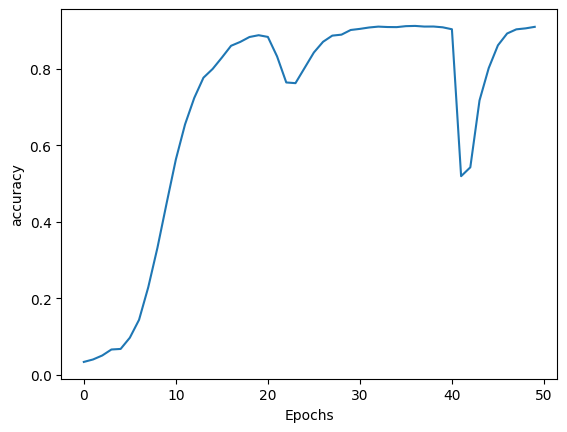

In [14]:
plot_graphs(history, 'accuracy')

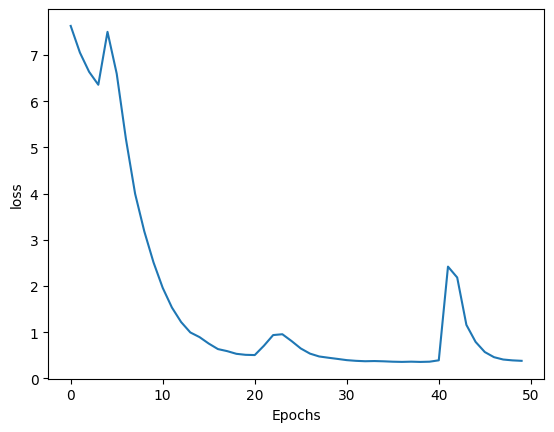

In [15]:


plot_graphs(history, 'loss')



In [20]:
model.save("next_word_prediction_model.h5")


In [18]:
model.save("next_word_prediction_model.keras")


# Varify model


In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
model = load_model("next_word_prediction_model.h5")

# Print the model architecture
model.summary()

# Define a function to predict the next word
def predict_next_word(model, tokenizer, seed_text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre'))
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    return output_word

# Example of using the model to predict the next word
seed_text = "The economy is"
next_word = predict_next_word(model, tokenizer, seed_text, max_sequence_len)
print(f"Seed text: '{seed_text}' -> Next word: '{next_word}'")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 18, 100)             │         369,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300)                 │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3693)                │       1,111,593 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,782,095 (6.80 MB)

 Trainable params: 1,782,093 (6.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Seed text: 'The economy is' -> Next word: 'spiffing'


In [21]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

def generate_text(model, tokenizer, seed_text, max_sequence_len, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        # Predict the next word
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted, axis=1)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        seed_text += " " + output_word
    return seed_text

# Example usage
seed_text = "I am"
next_words = 5
generated_text = generate_text(model, tokenizer, seed_text, max_sequence_len, next_words)
print(generated_text)


I am part of a new alliance


In [23]:

# Define a function to predict the next word
def predict_next_word(model, tokenizer, seed_text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre'))
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    return output_word

# Interactive prompt
while True:




    seed_text = input("Enter seed text (or 'exit' to quit): ")
    if seed_text.lower() == 'exit':
        break
    next_word = predict_next_word(model, tokenizer, seed_text, max_sequence_len)
    print(f"Seed text: '{seed_text}' -> Next word: '{next_word}'")

Enter seed text (or 'exit' to quit): b
1/1 [==============================] - 0s 19ms/step
Seed text: 'b' -> Next word: 'i'
Enter seed text (or 'exit' to quit): 
1/1 [==============================] - 0s 20ms/step
Seed text: '' -> Next word: 'is'
Enter seed text (or 'exit' to quit): 
1/1 [==============================] - 0s 18ms/step
Seed text: '' -> Next word: 'is'
Enter seed text (or 'exit' to quit): 
1/1 [==============================] - 0s 27ms/step
Seed text: '' -> Next word: 'is'
Enter seed text (or 'exit' to quit): 
1/1 [==============================] - 0s 18ms/step
Seed text: '' -> Next word: 'is'
Enter seed text (or 'exit' to quit): 
1/1 [==============================] - 0s 17ms/step
Seed text: '' -> Next word: 'is'
Enter seed text (or 'exit' to quit): 
1/1 [==============================] - 0s 18ms/step
Seed text: '' -> Next word: 'is'
Enter seed text (or 'exit' to quit): 
1/1 [==============================] - 0s 18ms/step
Seed text: '' -> Next word: 'is'
Enter seed text

KeyboardInterrupt: Interrupted by user

In [24]:
pip install --upgrade tensorflow keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo